# MPlot how-to
This notebook is a tutorial for the use of the methods defined in nbs\mplots.ipybn for analyzig MPlots. This tool is introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!

In [1]:
#| export
print_flag                    = True
reset_kernel                  = True
pre_configured_case           = True
case_id                       = 7
frequency_factor              = 1
frequency_factor_change_alias = True
cuda_device                   = 1

In [2]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

In [3]:
#| export
import dvats.config as cfg_

In [4]:
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


If you don't have the M-toy dataset. Please download it from [zenodo](https://zenodo.org/records/4328047/files/toy.csv). You can check more about it in [Stumpy](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html) and see our previous analysis at the [Original DeepVATS paper](https://www.sciencedirect.com/science/article/pii/S0950705123005439).

## Main code
### Import libraries

## Main code
### Import libraries

In [5]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f9d5913baf0>

















### Initialize and Configurate Artifact

#### Initialize Weights and Biases

In [6]:
#| export
wandb_api = wandb.Api()

#### Setup CUDA

In [7]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

gpu_device = torch.cuda.current_device()
print("GPU Device", gpu_device)
print("Device", device)
gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 11
GPU | Used mem: 24
GPU | Memory Usage: [█████████-----------] 46%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/06_MPlots.ipynb'

In [8]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

stride: 900 -> 1
wandb_group: None
data_fpath is missing in original dict | ~/data/toy.csv 
norm_by_sample: False
r: 0.71
alias: PulsusParadoxus-SP02 -> toy
freq is missing in original dict | 1s 
epochs: 100
valid_size: 0.2
artifact_name is missing in original dict | toy 
analysis_mode: online
data_cols is missing in original dict | [] 
w: 100 -> 30
valid_artifact: None
csv_config is missing in original dict | {} 
batch_size: 512 -> 32
norm_use_single_batch: False
mask_future: False
mask_sync: False
time_col is missing in original dict | None 
mask_stateful: True
mvp_ws: (15, 100) -> [10, 30]
norm_use_by_single_batch is missing in original dict | (False,) 
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest -> mi-santamaria/deepvats/toy:latest
use_wandb: True


### Setup Weights & biases artiffact

In [9]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="06_MPlots"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: 06_MPlots
alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [10, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 1
train_artifact: mi-santamaria/deepvats/toy:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
artifact_name: toy
data_cols: []
data_fpath: ~/data/toy.csv
freq: 1s
time_col: None
csv_config: {}
norm_use_by_single_batch: (False,)


In [10]:
job_type = 'MPlot'
job_type

'MPlot'

### Start W&B Run

In [11]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/06_MPlots.ipynb.


--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


### Generating the MPlots

#### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [12]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")

alias: toy
analysis_mode: online
batch_size: 32
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [10, 30]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 1
train_artifact: mi-santamaria/deepvats/toy:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None
artifact_name: toy
data_cols: []
data_fpath: ~/data/toy.csv
freq: 1s
time_col: None
csv_config: {}
norm_use_by_single_batch: [False]
---> W&B Train Artifact


In [13]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [14]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(550, 3)


<bound method NDFrame.head of                            T3        T2        T1
1970-01-01 00:00:00  0.741822  0.637180  0.565117
1970-01-01 00:00:01  0.739731  0.629415  0.493513
1970-01-01 00:00:02  0.718757  0.539220  0.469350
1970-01-01 00:00:03  0.730169  0.577670  0.444100
1970-01-01 00:00:04  0.752406  0.570180  0.373008
...                       ...       ...       ...
1970-01-01 00:09:05  0.634965  0.516560  0.780111
1970-01-01 00:09:06  0.637140  0.544686  0.802453
1970-01-01 00:09:07  0.639375  0.512788  0.853659
1970-01-01 00:09:08  0.616411  0.509230  0.817400
1970-01-01 00:09:09  0.569368  0.460593  0.839449

[550 rows x 3 columns]>

df_train ~  (550, 3)
window_sizes =  [10, 30]
wlen =  30


In [15]:
import dvats.mplots as mplots

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
import pyscamp as scamp
import dvats.memory as mem

In [17]:
mem.gpu_memory_status()

GPU | Used mem: 23
GPU | Used mem: 24
GPU | Memory Usage: [███████████████████-] 96%


In [18]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = scamp.gpu_supported()
has_gpu_support

True

In [19]:
ts_step = 1
#the most relevant is T3
ts = df_train.iloc[:,1].values[::ts_step]
print(len(ts))

550


In [20]:
subsequence_len = config.w
print(subsequence_len)

30


#### Compute MPlot

In [21]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = subsequence_len,
    self_join       = False
)

In [22]:
#| hide
print("MP_AB self_join", data_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {data_MPlot.DM_AB.shape}")
print("MP_AB method:", data_MPlot.MP_AB.method)
print("DM_AB method:", data_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


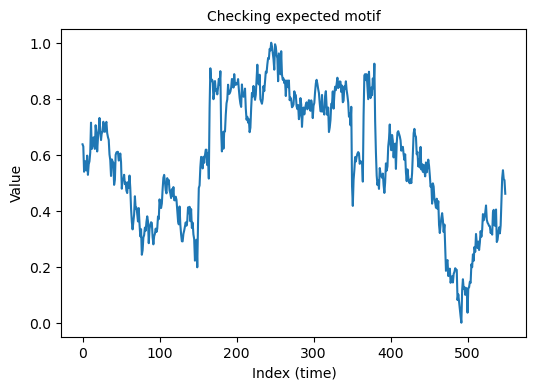

In [23]:
mplots.plot_with_dots(
    time_series = data_MPlot.data,
    title = "Checking expected motif", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (6,4)
)

In [24]:
mp_method = 'stump'
dm_method = 'stump'

In [25]:
# Threshold per method
threshold_scamp = 5
threshold_stump = 7.6
#Select the threshold for the method used for the computation
threshold = threshold_stump if data_MPlot.DM_AB.method == 'stump' else threshold_scamp

In [26]:
data_MPlot.compute(
    mp_method           = mp_method, 
    dm_method           = dm_method,
    d                   = mplots.z_normalized_euclidean_distance,
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    subsequence_len     = subsequence_len,
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

[ MPlot | Compute ] | -->  Downsample 
[ MPlot | Compute ] | Downsample TA ~ 550 ---> 
[ MPlot | Compute ] | Downsample TB_paa ~ 550 ---> 
[ MPlot | Compute ] |Downsample -->
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 550 ---> 
Ensure valid limits | Original [0, 550]
Final [0, 550]
Ensure valid limits | Original [0, 550]
Final [0, 550]
--> matrix profile
Not parallel
matrix profile 1.3329734802246094 seconds -->


In [27]:
n_a = len(data_MPlot.data)
n_b = len(data_MPlot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - data_MPlot.subsequence_len + 1)
print("Columns: ", n_a - data_MPlot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {data_MPlot.DM_AB.method} --")
print(data_MPlot.DM_AB.shape)
print(f"-- MP dimension using {data_MPlot.MP_AB.method}")
print(len(data_MPlot.MP_AB.distances))
print("-- DM Values --")
print(data_MPlot.DM_AB.distances)
print("-- MP values --")
print(data_MPlot.MP_AB.distances)

-- DM Expected dimensions -- 
Rows:  521
Columns:  521
-- Obtained shape when computing using  stump --
(521, 521)
-- MP dimension using stump
521
-- DM Values --
[[0.         4.55323348 5.11584256 ... 7.38526243 6.72177072 6.61602527]
 [       inf        inf        inf ... 7.33400191 7.07861952 6.55167952]
 [       inf        inf        inf ... 6.9667681  7.03742747 6.91150299]
 ...
 [7.38526243 7.33400191 6.9667681  ...        inf        inf        inf]
 [6.72177072 7.07861952 7.03742747 ...        inf        inf        inf]
 [6.61602527 6.55167952 6.91150299 ...        inf        inf        inf]]
-- MP values --
[3.2604684360557283 3.2932123473172523 3.196270015122442
 3.2898357228649564 3.4425189500189046 3.53395300866435 4.069260920590673
 4.008205686797713 4.192644453185017 4.341836006662531 3.8869330553953527
 3.620220651878686 3.5774337196296293 3.2610008964386616 3.337973989526764
 3.3505039620629065 3.3635498216829554 3.217270121445801 3.237926971355116
 3.013248428180473 2.7

In [28]:
data_MPlot.MP_AB.get_anomaly_idx()
print(data_MPlot.MP_AB.discord_idx)
print(data_MPlot.MP_AB.discord_nearest_neighbor_idx)
print(data_MPlot.MP_AB.discord_nearest_neighbor_idx_left)
print(data_MPlot.MP_AB.discord_nearest_neighbor_idx_right)

273
338
66
338


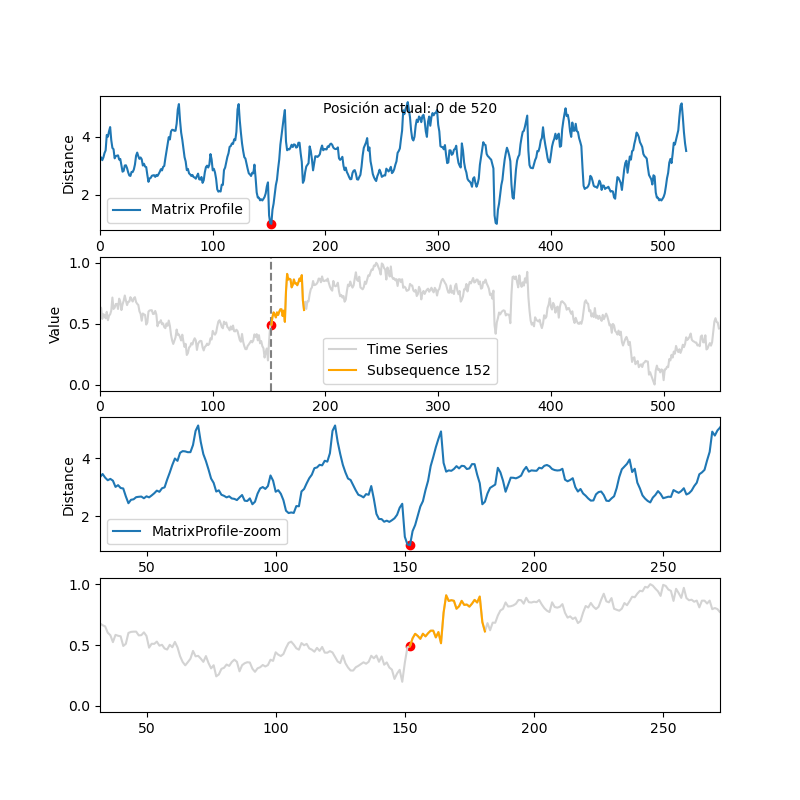

In [29]:
%matplotlib widget
data_MPlot.MP_AB.plot_interactive(
    figsize = (8,8),
    print_flag =  False
)

Looking for approximately this indexes

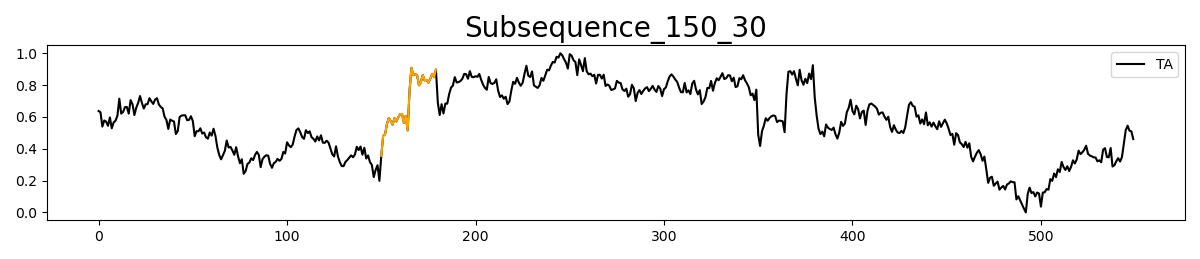

In [30]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 30*5,
    subsequence_len = subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    subsequence_color = "orange",
    sequence_color = 'black'
)

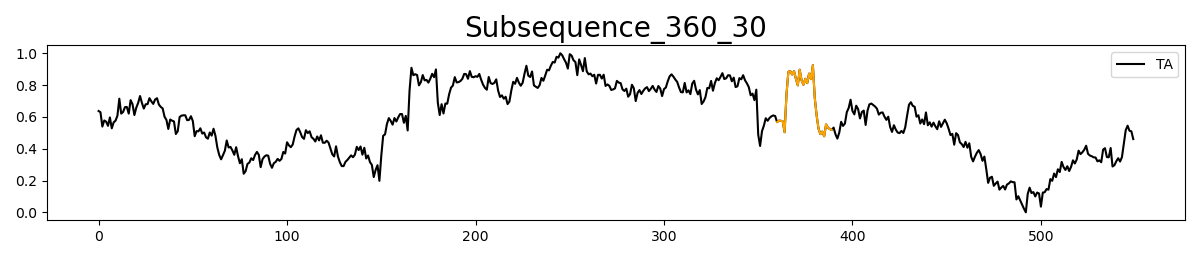

In [31]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 30*12,
    subsequence_len = subsequence_len,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    subsequence_color = "orange",
    sequence_color = "black"
)

what does the MPlot says?

Threshold:  5
Plot check limits | Original range: r( None , None ) c( None , None )
Plot check limits | CRange0: r( 0 , 550 ) c( None , None )
Plot check limits | CRange1: r( 0 , 550 ) c( 0 , None )
Plot check limits | CRange2: r( 0 , 550 ) c( 0 , 550 )
Plot check limits | Final range: r( 0 , 550 ) c( 0 , 550 )
r_start 0
r_end 550
c_start 0
c_end 550
nr 551
nc 551
MPlot | Plot DM | DM_AB[0:550, 0:550] ~ (521, 521)
Plotting as MATLAB


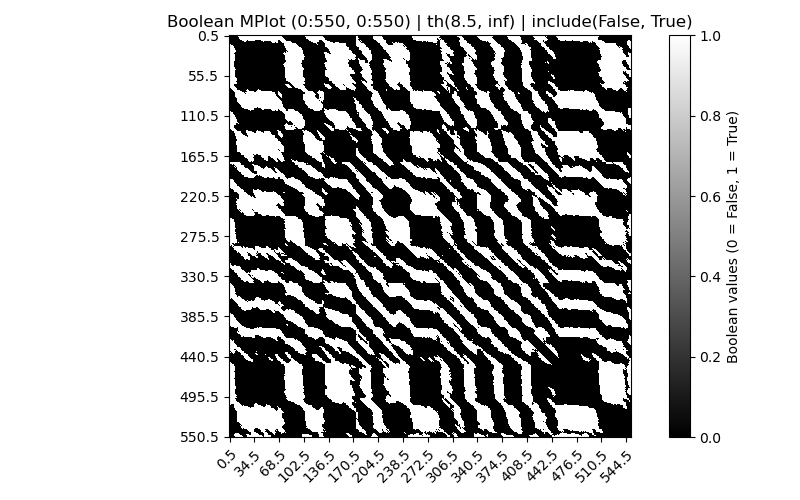

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [42]:
print("Threshold: ", threshold)
data_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (8,5),
    print_flag   = True,
    less_labels  = True,
    #r_min        = 0,
    #r_max        = 1000,
    #c_min        = 4500,
    #c_max        = 6000,
    dm_filter    = mplots.threshold_interval,
    th_min       = 8.5,
    th_max       = np.inf,
    include_min  = False,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    print_depth  = 1
)

Threshold:  5
Plot check limits | Original range: r( 0 , 150 ) c( 50 , 200 )
Plot check limits | CRange0: r( 0 , 150 ) c( 50 , 200 )
Plot check limits | CRange1: r( 0 , 150 ) c( 50 , 200 )
Plot check limits | CRange2: r( 0 , 150 ) c( 50 , 200 )
Plot check limits | Final range: r( 0 , 150 ) c( 50 , 200 )
r_start 0
r_end 150
c_start 50
c_end 200
nr 151
nc 151
MPlot | Plot DM | DM_AB[0:150, 50:200] ~ (100, 521)
Plotting as MATLAB


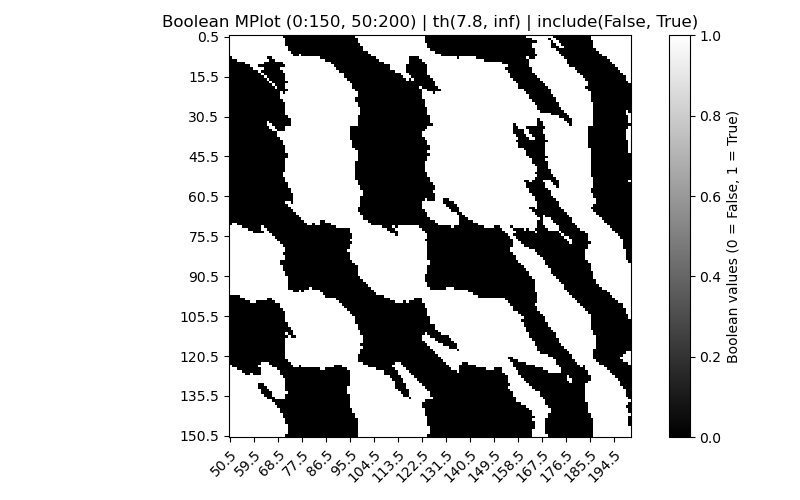

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [33]:
print("Threshold: ", threshold)
data_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (8,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = 0,
    r_max        = 150,
    c_min        = 50,
    c_max        = 200,
    dm_filter    = mplots.threshold_interval,
    th_min       = 7.8,
    th_max       = np.inf,
    include_min  = False,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    print_depth  = 1
)

Threshold:  5
Plot check limits | Original range: r( 0 , 300 ) c( 250 , 550 )
Plot check limits | CRange0: r( 0 , 300 ) c( 250 , 550 )
Plot check limits | CRange1: r( 0 , 300 ) c( 250 , 550 )
Plot check limits | CRange2: r( 0 , 300 ) c( 250 , 550 )
Plot check limits | Final range: r( 0 , 300 ) c( 250 , 550 )
r_start 0
r_end 300
c_start 250
c_end 550
nr 301
nc 301
MPlot | Plot DM | DM_AB[0:300, 250:550] ~ (50, 521)
Plotting as MATLAB


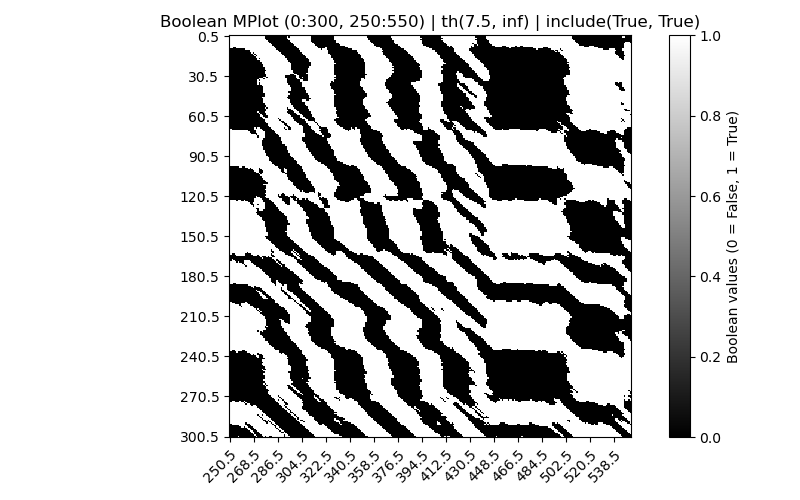

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [34]:
print("Threshold: ", threshold)
data_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (8,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = 0,
    r_max        = 300,
    c_min        = 250,
    c_max        = 550,
    dm_filter    = mplots.threshold_interval,
    th_min       = 7.5,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    print_depth  = 1
)